In [1]:
import numpy as np
import math
import pandas as pd
import scipy.spatial.distance as dis
import matplotlib.pyplot as plt
import numpy.random as rand
import scipy.stats as stats
import scipy.misc as misc
import scipy.special as special
import scipy.spatial.distance as dis
from scipy.optimize import bisect as bisect
from scipy.optimize import minimize as minimize
from collections import Counter
import seaborn as sns
from sklearn.manifold import TSNE

First, I implement a PCA algorithm to cluster this RNA-seq data; becasue PCA does a linear projection of data points to 2D space, however, this method fails on this dataset (of which there is no appropriate linear projection). \

Next, I implement a t-SNE algorithm from first principles to cluster the data better, and compare my method to a canned t-SNE command in sklearn.

In [2]:
#Get data
! wget -o - "http://mcb112.org/w13/w13-data-small.tbl" > log.log
! wget -o - "http://mcb112.org/w13/w13-data-large.tbl" > log.log

In [3]:
with open('w13-data-small.tbl', 'r') as f:
    small = pd.read_table(f, delim_whitespace=True)
f.close()

with open('w13-data-large.tbl', 'r') as f:
    large = pd.read_table(f, delim_whitespace=True)
f.close()

In [4]:
types_small = small['type']
types_large = large['type']
small = small.drop(['type'], axis = 1)
large = large.drop(['type'], axis = 1)

In [5]:
genes_small = small.columns
genes_large = large.columns

From this point on in this question, I perform PCA on the small and large datasets in the exact same manner as done in the previoius problem set.

In [6]:
#adding 1 count to all cells to deal with log(0) issue
small = np.log(np.array(small+1))
large = np.log(np.array(large+1))

I start by performing SVD.

In [7]:
new_small = pd.DataFrame(small)
new_small.columns = genes_small

#From every cell, subtracts the mean of its column to center the data
for column in new_small.columns:
    new_small[column] = new_small[column] - new_small[column].mean()

new_large = pd.DataFrame(large)
new_large.columns = genes_large

#From every cell, subtracts the mean of its column to center the data
for column in new_large.columns:
    new_large[column] = new_large[column] - new_large[column].mean()

In [8]:
#SVD
U_s, s_s, Wt_s = np.linalg.svd(new_small, full_matrices = False)

In [9]:
U_lg, s_lg, Wt_lg = np.linalg.svd(new_large, full_matrices = False)

Next, I get the first two principal components

In [10]:
W_q_s = Wt_s[0:2].transpose()
W_q_lg = Wt_lg[0:2].transpose()

In [11]:
Y_q_s = small @ W_q_s
Y_q_lg = large @ W_q_lg

Finally, I plot the projection onto 2D space of the two principal components using the small data, and then in the following line the large data.

In [12]:
groups = []
for i in range(8):
    indices = [j for j,x in enumerate(list(types_small)) if x == i]
    groups.append(indices)

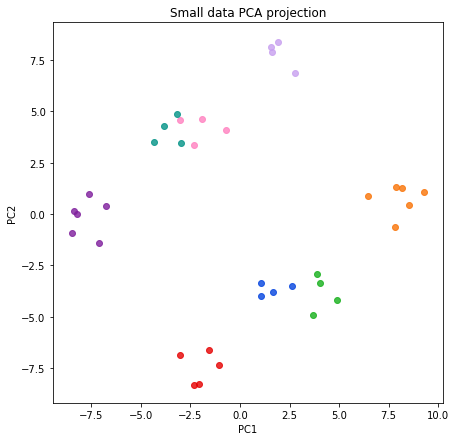

In [13]:
fig, ax = plt.subplots(1, figsize=(7,7))
colors = ['xkcd:red',    'xkcd:green',  'xkcd:blue',   'xkcd:orange', 
          'xkcd:purple', 'xkcd:pink',   'xkcd:teal',   'xkcd:lavender', 'xkcd:navy', 
          'xkcd:crimson',  'xkcd:mustard',   'xkcd:rose', 
          'xkcd:salmon', 'xkcd:bright purple',   'xkcd:rust',   'xkcd:puce',]

for i, element in enumerate(groups): 
    plot = sns.regplot(x = Y_q_s[element,0], y = Y_q_s[element,1], fit_reg = False, color = colors[i]);
plot.set(xlabel = "PC1", ylabel = "PC2", title = "Small data PCA projection");

In [14]:
groups_large = []
for i in range(16):
    indices = [j for j, x in enumerate(list(types_large)) if x == i]
    groups_large.append(indices)

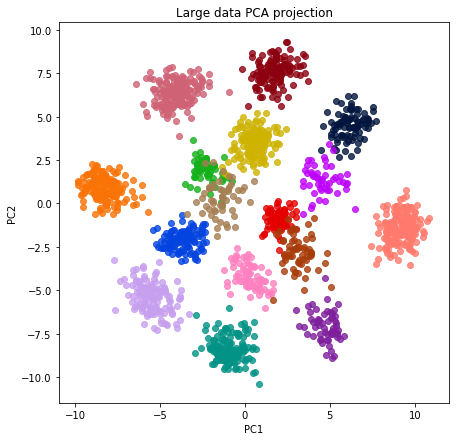

In [15]:
fig, ax = plt.subplots(1, figsize=(7,7))
for i, element in enumerate(groups_large):
    plot = sns.regplot(x = Y_q_lg[element,0], y = Y_q_lg[element,1], fit_reg = False, color = colors[i]);
plot.set(xlabel = "PC1", ylabel = "PC2", title = "Large data PCA projection");

As we expected, this clustering doesn't allow Moriarty to effectively cluster his data. This experiment is a good example of one of the limiting factors of PCA. PCA works by finding the linear projection onto 2D space of the data points as rotated into the configuration that maximizes their variance. However, it is still a linear projection, and in this example of a hypercube with clusters around the points of the cube, there is no good way to rotate the data in space for which the projection into 2D on their principle components would provide good clustering. In order to remedy this, we can use t-SNE, which doesn't assume any kind of linear projection and thus could provide a much more effective way to segregate the data points into their respective clusters. 

# Problem 2

In this problem, I implement t-SNE as a different method of clustering Moriarty's data. t-SNE does not preserve the layout of the data in space, but because it does not perform this kind of linear projection, it will likely be a better method of clustering this data. 

My implementation of t-SNE involves many subfunctions, the first of which, below, finds the Shannon entropy for a given point x_i.

In [16]:
def get_H_i(sigma_i, x_i, X):
    denom = 0
    for x_j in X:
        if np.array_equal(x_j,x_i)==False:
            denom += np.exp(-((dis.euclidean(list(x_i), list(x_j)))**2)/(2*(sigma_i**2)))
    H_i = 0
    for x_j in X:
        if np.array_equal(x_j,x_i)==False:
            numerator = np.exp(-(dis.euclidean(list(x_j), list(x_i))**2/(2*(sigma_i**2))))
            p_j_given_i = (numerator/denom)*np.log(numerator/denom)
            H_i += p_j_given_i
    H_i = -(H_i)
    return H_i

Below is the function which returns $2^{H_i}$ minus perplexity, which is the function for which we need to find the roots for every point in the small set

In [17]:
def find_sigma(sigma_i, x_i, X, perplexity):
    H_i = get_H_i(sigma_i, x_i, X)
    return (2**H_i - perplexity)

In order to get the lower and upper bounds, I use the method of finding the roots of where the f(lower) is an opposite sign as f(upper) detailed in section.

In [18]:
#from section notes
lower_bound_guess = 0.5 
while find_sigma(lower_bound_guess, small[0], small, 5) > 0: 
    lower_bound_guess /= 2 
upper_bound_guess = lower_bound_guess
while find_sigma(upper_bound_guess, small[0], small, 5) < 0:
    upper_bound_guess *= 2 
lower_bound = lower_bound_guess
upper_bound = upper_bound_guess

In [19]:
sigmas = []
for i in range(len(small)):
    sigmas.append(bisect(find_sigma, lower_bound, upper_bound, args = (small[i], small, 5)))

Here, I use matrix algebra to get our matrix P, containing in every cell $i,j$ the joint probability $p_{ij}$ according to the formula given to us in lecture.

In [20]:
def get_P(X, sigmas):
    #get distance matrix
    matrix = dis.cdist(X,X)
    sigmas_matrix = np.tile(sigmas, (len(sigmas), 1))
    
    num_j_given_i = np.exp(-((matrix**2)/(2*(sigmas_matrix**2))))
    num_i_given_j = np.exp(-((matrix**2)/(2*(sigmas_matrix.transpose()**2))))
    
    denom_j_given_i = np.exp(-((matrix**2)/(2*(sigmas_matrix**2))))
    np.fill_diagonal(denom_j_given_i, 0)
    denom_j_given_i = np.sum(denom_j_given_i, axis = 1)
    denom_j_given_i = np.tile(denom_j_given_i, (len(denom_j_given_i), 1))
    
    denom_i_given_j = np.exp(-((matrix**2)/(2*(sigmas_matrix.transpose()**2))))
    np.fill_diagonal(denom_i_given_j, 0)
    denom_i_given_j = np.sum(denom_i_given_j, axis =1)
    denom_i_given_j = np.tile(denom_i_given_j, (len(denom_i_given_j), 1))
    
    #get matrices containing p(i|j) and p(j|i) 
    pi_given_j = num_i_given_j/denom_i_given_j
    pj_given_i = num_j_given_i/denom_j_given_i

    #Get matrix P containing all joint probabilities
    P = (pi_given_j + pj_given_i)/(2*len(X))
    np.fill_diagonal(P, 1)

    return P

The following function gets my starting points on the 2D plane, picked randomly from a Gaussian distribution with mean 0 and variance of $10^{-4}$

In [21]:
def get_initial_y(X):
    mu, sigma = 0, 0.0001
    init_y = np.random.normal(mu, sigma, (len(X), 2))
    return (init_y)

The following function gets the matrix Q, where each cell $i,j$ contains the value $q_{ij}$ as defined in lecture.

In [22]:
def get_Q(Y):
    #get distance matrix
    matrix = dis.cdist(Y,Y)
    
    Q = 1/(1+matrix**2)
    denom_matrix = 1/(1+matrix**2)
    np.fill_diagonal(denom_matrix, 0)
    
    #get normalization constant
    denom = np.sum(denom_matrix)
    
    #normalize
    Q = Q/denom
    return Q

The following function finds the KL divergence between the Q and P matrices for given sigmas. This is the function which will be used in our optimization step.

In [23]:
def KL_new(Y, sigmas, X, P):
    Y = np.reshape(Y, (len(X),2))
    
    #Get Q matrix
    Q = get_Q(Y)
    distances = dis.cdist(Y,Y)
    
    #Get gradient
    gradient = np.zeros(Y.shape)
    for i, y_i in enumerate(Y):
        gradient[i] = 4*np.sum([list((P[i][j] - Q[i][j])*(np.subtract(y_i,y_j))*((1 + distances[i][j]**2)**(-1))) for j, y_j in enumerate(Y)], axis = 0)
    gradient = np.array(gradient)
    #Get KL
    KL_matrix = P*np.log(P/Q)
    np.fill_diagonal(KL_matrix, 0)
    KL_dist = np.sum(KL_matrix)
    
    return KL_dist, gradient.flatten()
    

Next, I run scipy.optimize.minimize to find the 2D points which best preserve the true clustering of the data according to the minimal KL divergence values they produce.

In [24]:
P = get_P(small, sigmas)
best_KL = float('inf')
best_y = []

#starting from 50 intial configurations
for i in range(50):
    init_Y = get_initial_y(small)
    result = minimize(KL_new, init_Y.flatten(), jac=True, args=(sigmas, small, P))
    KL_dist = result.fun
    if KL_dist < best_KL:
        best_KL = result.fun
        best_y = result.x

I plot my clusterings below.

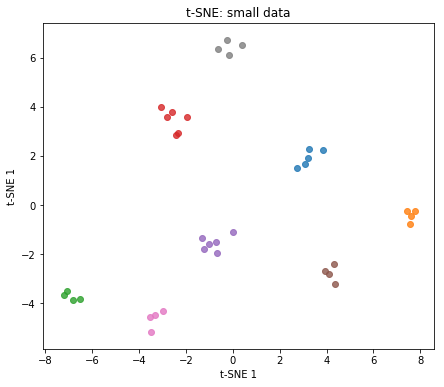

In [25]:
y = np.reshape(best_y, (len(small),2))
data = pd.DataFrame(y)
fig, ax = plt.subplots(1, figsize = (7,6))
for element in groups:
    plot = sns.regplot(x = data[0][element], y =data[1][element], fit_reg = False);
plot.set(xlabel = "t-SNE 1", ylabel = "t-SNE 1", title = "t-SNE: small data");

As expected, t-SNE successfully clusters the data from the small set where PCA failed. As explained above, this is because, while PCA projects data onto the 2D plane in a linear fashion, in this data set no such projection successfully maintains clusterings. However, t-SNE finds the most probable clusterings without maintaining the physical orientation in space, rather focusing on maintaining the groupings of points that are proximal without any linear projection. As we see here, the clustering worked. 

# Problem 3

Here, I perform the same process, this time using the canned scikit.manifold.TSNE()

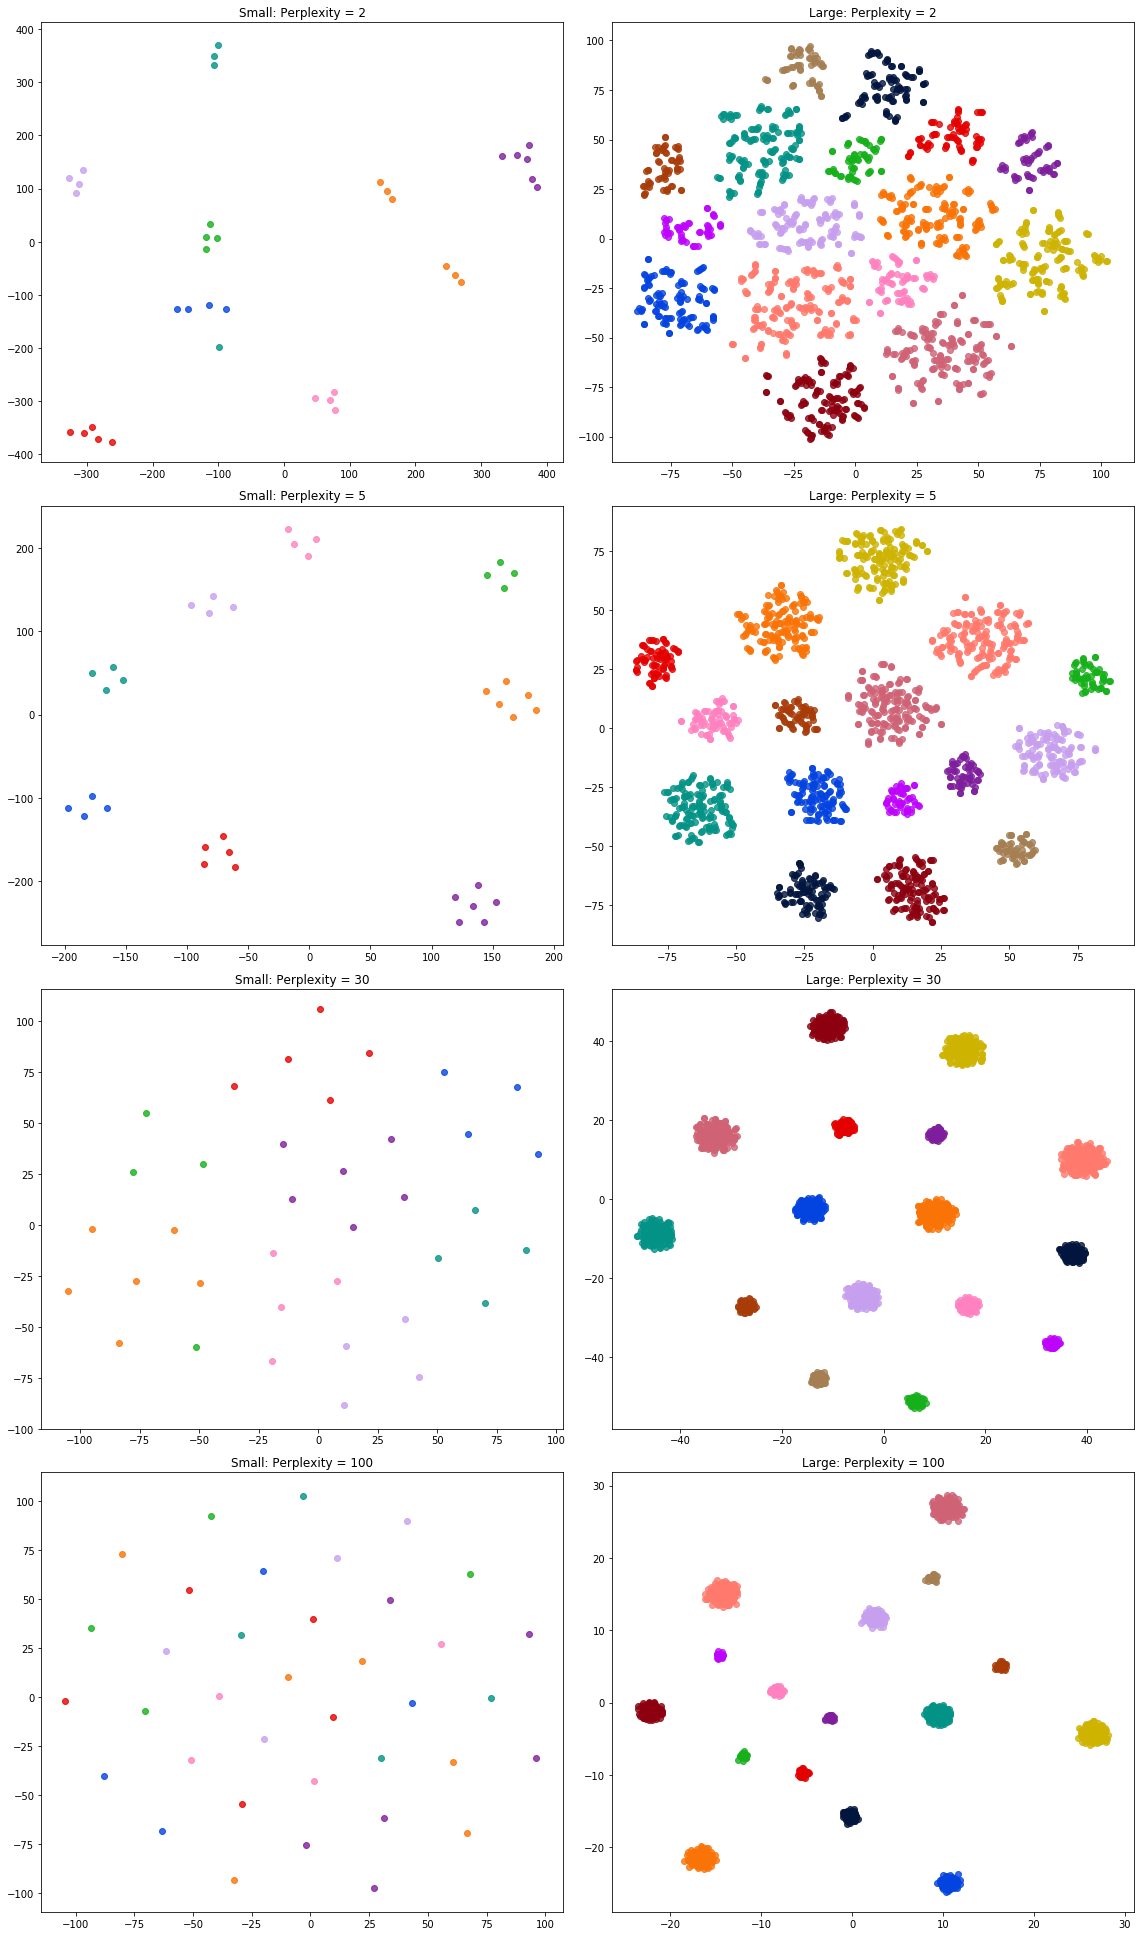

In [26]:
fig, ax = plt.subplots(4,2, figsize=(16,27))
col = 0
for i in [2, 5, 30, 100]:
    small_TSNE = TSNE(perplexity=i).fit_transform(small)
    large_TSNE = TSNE(perplexity=i).fit_transform(large)
    for m, element in enumerate(groups):
        s = sns.regplot(x = small_TSNE.transpose()[0][element], y = small_TSNE.transpose()[1][element], fit_reg = False, ax=ax[col][0], color = colors[m]);
    for k, element in enumerate(groups_large): 
        l = sns.regplot(x = large_TSNE.transpose()[0][element], y = large_TSNE.transpose()[1][element], fit_reg = False, ax=ax[col][1], color = colors[k]);
    col += 1
    s.set(title="Small: Perplexity = " + str(i));
    l.set(title="Large: Perplexity = " + str(i));

plt.tight_layout()

As we can see, the clustering using the canned scipy command works very well. On the larger data, it looks like any value of perplexity, especially 5 or above, works very well. On the small data set, we should note that the optimal perplexity appears to be 5. With perplexity above 5, however, the TSNE algorithm appears to lump all the small data into a single cluster; likely, this is because, since perplexity defines the number of points assigned as neighbors to each point, if the value of perplexity is close to (or more than) the total number of data points, the algorithm would consider almost every point to be every other point's neighbor, leading to the data being clustered all together.